# Lesson 1 - Keras implementation of fast ai part 1 v2
- This is a Keras implementation of Jeremy Howard's fastai part 1 v2 lesson 1 (original version is in PyTorch)
- This has only been tested with the TensorFlow backend to Keras

In [5]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from fastai.utils import *
from fastai.learner import *
from fastai.dataset import *

We will use the dogs and cats dataset

path should be replaced with the path to your downloaded dogs and cats dataset

For the original Keras dogs/cats lesson1 and instructions on downloading visit:
https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson1.ipynb

In [6]:
path="/home/jeff/projects/fastai/data/dogscats/" #update with your path to cats and dogs
sz = 224

Loading in Keras' off the shelf/pretrained ResNet50 model.

***note: the PyTorch course uses ResNet34. After many hours spent writing code to convert PyTorch models and weights into Keras. I opted to use Keras' ResNet50.***

In [14]:
arch = ResNet50
data = ImageClassifierData.from_paths(path=path, tfms = tfms_from_model(arch, sz, rescale=1/255))
learn = ConvLearner.pretrained(arch, data)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [8]:
learn.lr_find()

Epoch 1/1
198/360 [===============>..............] - ETA: 29s - loss: 0.4130

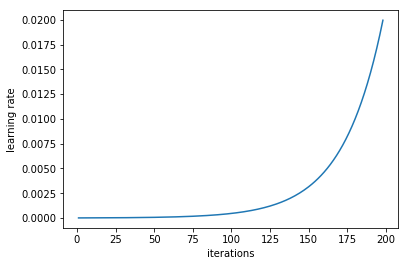

In [9]:
learn.sched.plot_lr()

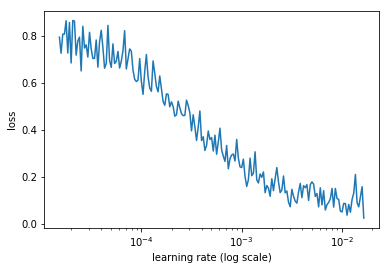

In [10]:
learn.sched.plot()

As you can see in the plot above it appears the optimal learning rate to set is .01, but i like to move fast so i'm going to use .08

**Data Augmentation on the training data**

Now time to start training!  I noticed that the pretrained Keras ResNet50 model is not quite as accurate in my opinion as the pretrained PyTorch ResNet50 model.

In [15]:
tfms = tfms_from_model(arch, sz, crop_type=CropType.RANDOM, 
                  rotation_range=10, zoom_range=0.1, horizontal_flip=True, rescale=1/255)

In [8]:
#need to add random lighten
data = ImageClassifierData.from_paths(path=path, tfms = tfms)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [16]:
learn.fit(.08, 4)

Epoch 1/4
360/360 [==============================] - 63s - loss: 0.4034 - acc: 0.9589    
Epoch 2/4
360/360 [==============================] - 63s - loss: 0.3083 - acc: 0.9698    
Epoch 3/4
360/360 [==============================] - 63s - loss: 0.3107 - acc: 0.9707    
Epoch 4/4
360/360 [==============================] - 63s - loss: 0.2502 - acc: 0.9764    


Evaluate function may run a little slow.  I find that Keras generator's are not the fastest compared to the ones in the fastai PyTorch library.  Generally I try to load the entire dataset into memory, but since this repository is meant to be shared I opted for generators so that it works for a wider audience.

In [18]:
learn.model.evaluate_generator(data[1], steps=math.ceil(data[1].samples/data[1].batch_size*4), workers=4)

[0.23228430883030457, 0.97721486761710796]

Fit for 3 epochs with a Cyclical Learning Rate

In [19]:
learn.fit(.08, 2, cycle_len=1, cycle_mult=2)

Epoch 1/3
360/360 [==============================] - 63s - loss: 0.2138 - acc: 0.9799    
Epoch 2/3
360/360 [==============================] - 63s - loss: 0.2609 - acc: 0.9757    
Epoch 3/3
360/360 [==============================] - 62s - loss: 0.1726 - acc: 0.9825    


In [20]:
learn.model.evaluate_generator(data[1], steps=math.ceil(data[1].samples/data[1].batch_size*4), workers=4)

[0.22270350520565041, 0.97899590163934425]

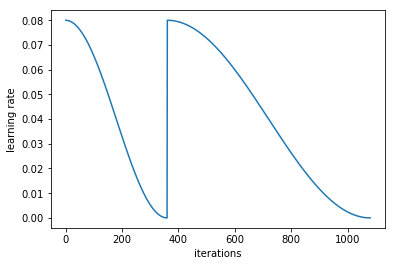

In [21]:
learn.sched.plot_lr()

In [22]:
learn.save('keras_resnet50.hdf5')

Make all layers trainable

In [23]:
learn.unfreeze()

In [24]:
learn.fit([0.0001, .001, .01], 3, cycle_len=1, cycle_mult=2)

Epoch 1/7
360/360 [==============================] - 205s - loss: 0.1469 - acc: 0.9847   
Epoch 2/7
360/360 [==============================] - 203s - loss: 0.1055 - acc: 0.9888   
Epoch 3/7
360/360 [==============================] - 203s - loss: 0.0753 - acc: 0.9922   
Epoch 4/7
360/360 [==============================] - 203s - loss: 0.0684 - acc: 0.9927   
Epoch 5/7
360/360 [==============================] - 203s - loss: 0.0480 - acc: 0.9946   
Epoch 6/7
360/360 [==============================] - 203s - loss: 0.0393 - acc: 0.9960   
Epoch 7/7
360/360 [==============================] - 203s - loss: 0.0375 - acc: 0.9967   


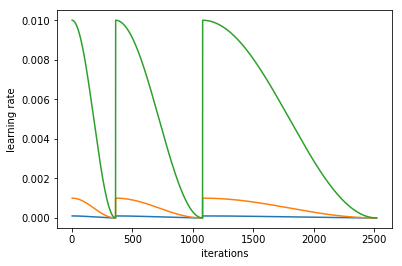

In [25]:
learn.sched.plot_lr()

In [26]:
%%time
learn.model.evaluate_generator(data[1], steps=math.ceil(data[1].samples/data[1].batch_size*4), workers=4 )

CPU times: user 23 s, sys: 1.36 s, total: 24.4 s
Wall time: 25.8 s


[0.14474294896546183, 0.98642418032786883]

In [27]:
learn.save('keras_resnet50_2.hdf5')